In [1]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import math
import networkx as nx
import sys
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [2]:
proj_crs = "EPSG:7856"

## Import Data

Data sources:
1. Shape of Greater Adelaide - used to clip points
2. Points of interest from OSM
3. Adelaide Metro public transport stops


In [6]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Colouring data & results\\Canberra Data\\"
data = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Data\\"
Greater_Adelaide = gpd.read_file((folder + 
    "Canberra GCCSA.gpkg")
    ).to_crs(proj_crs)

In [7]:
osm_poi_points = gpd.read_file(''.join((data, 
    "OSM-australia-latest-free\\gis_osm_pois_free_1.shp")))
osm_poi_areas = gpd.read_file(data + 
    "OSM-australia-latest-free\\gis_osm_pois_a_free_1.shp")
osm_transport_points = gpd.read_file(data +
    "OSM-australia-latest-free\\gis_osm_transport_free_1.shp")
osm_transport_areas =  gpd.read_file(data +
    "OSM-australia-latest-free\\gis_osm_transport_a_free_1.shp")
osm_parks_vertices = gpd.read_file(''.join((data, 
    "OSM-australia-latest-free\\OSM parks vertices.gpkg")))

In [ ]:
metro = gpd.read_file(folder + "unique_stops_types.csv")
metro.geometry = gpd.points_from_xy(metro['stop_lon'], metro['stop_lat'])
metro.crs = "EPSG:7843"
metro = metro.to_crs(proj_crs)

Convert polygonal datasets to points and any multipart datasets to single part.

In [8]:
osm_pois_2 = single_points(osm_poi_areas)
osm_transport_2 = single_points(osm_transport_areas)

osm_df = pd.concat([osm_poi_points, osm_pois_2, osm_transport_points, 
                    osm_transport_2]).to_crs(proj_crs)

### Categorise and weight POIs

Categorise POI data - change classes depending on your analysis and your data sources.

In [10]:
#metro_categories = {'transport':['bus'], 'trains':['train','tram']}

#metro_categorised = categorise_pois(metro, metro_categories, 
                                 category_column='service_type')

osm_categories = {"eating" : ['restaurant', 'pub', 'cafe', 'fast_food', 
                              'food_court', 'bakery', 'bar', 'nightclub', 'biergarten'], 
                  'groceries' : ['supermarket', 'chemist', 'pharmacy', 'greengrocer', 
                                 'convenience', 'butcher', 'beverages', 'alcohol'], 
                  'shopping' : ['mall', 'bicycle_shop', 'clothes', 
                                'department_store', 'doityourself', 
                                'outdoor_shop', 'stationery', 'bookshop', 
                                'gift_shop', 'newsagent', 'car_dealership', 
                                'kiosk', 'furniture_shop', 'sports_shop', 
                                'garden_centre', 'computer_shop', 'shoe_shop', 
                                'beauty_shop', 'florist', 'video_shop', 'toy_shop', 
                                'mobile_phone_shop', 'jeweller', 'travel_agent'], 
                  'errands' : ['post_box', 'post_office', 'bank', 'atm',
                               'doctors', 'dentist', 'laundry', 'hospital',
                               'car_wash', 'veterinary', 'hairdresser', 'optician'], 
                  'parks' : ['viewpoint', 'park', 'playground', 'picnic_site', 
                             'pitch', 'swimming_pool', 'sports_centre', 
                             'golf_course', 'track', 'dog_park'], 
                  'education' : ['college', 'school', 'kindergarten', 'university'], 
                  'entertainment' : ['library', 'attraction', 'stadium', 
                                     'arts_centre', 'theatre', 'artwork', 
                                     'archaeological', 'cinema', 'museum', 
                                     'ruins', 'observation_tower', 
                                     'community_centre', 'zoo', 'castle', 
                                     'theme_park', 'ice_rink'], 
                 'trains' : ['ferry_terminal', 'railway_station', 'bus_station', 
                             'tram_stop', 'railway_halt', 'publictransport'], 
                 'transport' : ['car_sharing', 'bus_stop']}

osm_categorised = categorise_pois(osm_df, osm_categories, 
                                  category_column='fclass')

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 8)

Need to remove potential overlap between different data sources (and inside some data sources). For this dataset it's around 30% because there is overlap of public transport stops between OSM and TfNSW, and overlap of things like post offices between OSM and SSNSW. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [ ]:
pois = remove_duplicate_pois([osm_categorised, 
                              #SS_categorised, 
                              #metro_categorised]
                              , buffer=10)

pois = gpd.clip(pois, greater_Canberra)

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [1]:
poi_weights = {
    "eating": [4, 3, 3, 2, 2, 2, 1, 1, 1, 1],
    "groceries": [10, 5],
    "shopping": [3, 3, 3, 2.5, 2.5],
    "errands": [7, 5, 3],
    "parks": [6],
    "education": [10],
    "entertainment": [5],
    "trains": [10],
    "transport": [2.5, 2.5]
}

In [2]:
category_sums = {k: sum(v) for k, v in poi_weights.items()}
total = sum(category_sums.values())
print(category_sums)
print("total: ", total)

{'eating': 20, 'groceries': 15, 'shopping': 14.0, 'errands': 15, 'parks': 6, 'education': 10, 'entertainment': 5, 'trains': 10, 'transport': 5.0}
total:  100.0


### Import network

In this case the network is already in the same projected CRS as everything else but I have left in the transformation to be clear.

In [15]:
# reading directly with geopandas.read_file crashes on my computer so I read into pandas then convert to gdf instead
edges_df = pd.read_csv("adelaide_edges_2_length.csv")
nodes_df = pd.read_csv("adelaide_nodes_2.csv")
edges = gpd.GeoDataFrame(edges_df, 
                         geometry=gpd.GeoSeries.from_wkt(edges_df['geometry'])).set_crs(proj_crs)
nodes = gpd.GeoDataFrame(nodes_df, 
                         geometry=gpd.GeoSeries.from_wkt(nodes_df['geometry'])).set_crs(proj_crs)
edges = edges.to_crs(proj_crs)
nodes = nodes.to_crs(proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (3,4,5,7,8,9,10,15,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (6,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'str'>
<class 'str'>


Pandana expects edges to have a two item index based on the same IDs as the node index.

In [16]:
nodes.set_index('connect_id',inplace=True)

edges['from_idx'] = edges['from']
edges['to_idx'] = edges['to']
edges= edges.set_index(['from_idx', 'to_idx'])
edges.index.names= ['from_idx','to_idx']

Pandana network creation.

In [17]:
distance_network = pdna.Network(nodes['x'], nodes['y'],
                                   edges['from'], edges['to'], 
                                   edges[['length']])

maximum_dist = 2400

Pandana network querying. The 'employment' category is empty because we didn't add the employment points to the POI dataset.

In [18]:
results = walk_index(distance_network, pois, poi_weights, distance=maximum_dist)  

Category employment is empty
Finished category: eating
Finished category: groceries
Finished category: shopping
Finished category: errands
Finished category: parks
Finished category: education
Finished category: entertainment
Finished category: trains
Finished category: transport


In [24]:
results.to_csv("Adelaide_colournoemployment_110222.csv")

In [23]:
type(results)

pandas.core.frame.DataFrame

AttributeError: 'PathCollection' object has no property 'column'

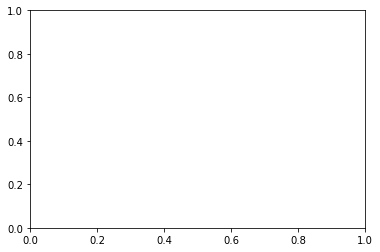

In [22]:
results.plot(kind='scatter', x='x', y='y', s=0.1, column='Walk_Index')

## Export results

Filter the results to property parcels only. Optionally export results as a csv.

In [ ]:
parcel_results = results.filter(items=nodes[nodes['connect_type'] == 'poi'].index, axis=0)

In [ ]:
parcel_results.to_csv("Adelaide_base_results_11.2.22.csv")

Import building footprints and join the data to them, then export these polygons.

In [ ]:
results_gdf = gpd.GeoDataFrame(parcel_results, geometry = gpd.GeoSeries.from_xy(building_results.x, building_results.y, crs="EPSG:7856"))

parcels = gpd.read_file(folder +
    "Data\\Colouring\\Building Footprints\\sydney_bf.shp").to_crs(proj_crs)

# join to data
parcels = gpd.sjoin(buildings_foot, results_gdf, how='left', predicate='contains')

parcels.to_file("Adelaide_base_results_11.2.22.gpkg")